In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns

import scipy.stats as stats
from scipy.interpolate import interp1d

from loess.loess_1d import loess_1d as loess

plt.rcParams['axes.linewidth'] = 1.5

In [2]:
df = pd.read_csv('Data/MeiklejohnCa.csv')
# Remove samples that do not have d44Ca values, store as df_ca
df_ca = df.dropna(subset=['d44Ca', 'd13C'])

df_src= df.dropna(subset=['Sr/Ca', 'd13C'])

df_srca= df.dropna(subset=['Sr/Ca', 'd44Ca'])

df_mgca= df.dropna(subset=['Mg/Ca', 'd44Ca'])
df_mgca = df_mgca[df_mgca['Mg/Ca']<150]

df_mgc= df.dropna(subset=['Mg/Ca', 'd13C'])
df_mgc = df_mgc[df_mgc['Mg/Ca']<150]

dx = pd.read_csv('Data/MeiklejohnC.csv')

In [3]:
# Export as numpy arrray
d44Ca = df_ca['d44Ca'].to_numpy()
meter_ca = df_ca['Meterage'].to_numpy()
d13C = dx['d13c'].to_numpy()
meter_c = dx['Meter'].to_numpy()
SrCa = df_src['Sr/Ca'].to_numpy()
meter_sr = df_src['Meterage'].to_numpy()

# Resampled array into 0.1 meter interval
meter = np.arange(meter_sr.min(), meter_sr.max(), 0.1)

# resample
f = interp1d(meter_ca, d44Ca)
d44Ca_resampled = f(meter)

f = interp1d(meter_c, d13C)
d13C_resampled = f(meter)

f = interp1d(meter_sr, SrCa)
SrCa_resampled = f(meter)

In [4]:
def subplots_centered(nrows, ncols, figsize, nfigs):
    """
    Modification of matplotlib plt.subplots(),
    useful when some subplots are empty.
    
    It returns a grid where the plots
    in the **last** row are centered.
    
    Inputs
    ------
        nrows, ncols, figsize: same as plt.subplots()
        nfigs: real number of figures
    """
    assert nfigs < nrows * ncols, "No empty subplots, use normal plt.subplots() instead"
    
    fig = plt.figure(figsize=figsize)
    axs = []
    
    m = nfigs % ncols
    m = range(1, ncols+1)[-m]  # subdivision of columns
    gs = gridspec.GridSpec(nrows, m*ncols)

    for i in range(0, nfigs):
        row = i // ncols
        col = i % ncols

        if row == nrows-1: # center only last row
            off = int(m * (ncols - nfigs % ncols) / 2)
        else:
            off = 0

        ax = plt.subplot(gs[row, m*col + off : m*(col+1) + off])
        axs.append(ax)
        
    return fig, axs

In [5]:
# Calculate pearson r and p values
rcca, pcca = stats.spearmanr(d44Ca_resampled, d13C_resampled)
rcsr, pcsr = stats.spearmanr(SrCa_resampled, d13C_resampled)
rcasr, pcasr = stats.spearmanr(d44Ca_resampled, SrCa_resampled)


Rs = [rcsr, rcasr, rcca]
Ps = [pcsr, pcasr, pcca]
Xs = [SrCa_resampled, d44Ca_resampled, d44Ca_resampled]
Ys = [d13C_resampled, SrCa_resampled,d13C_resampled]

Text(0, 0.5, 'Meterage')

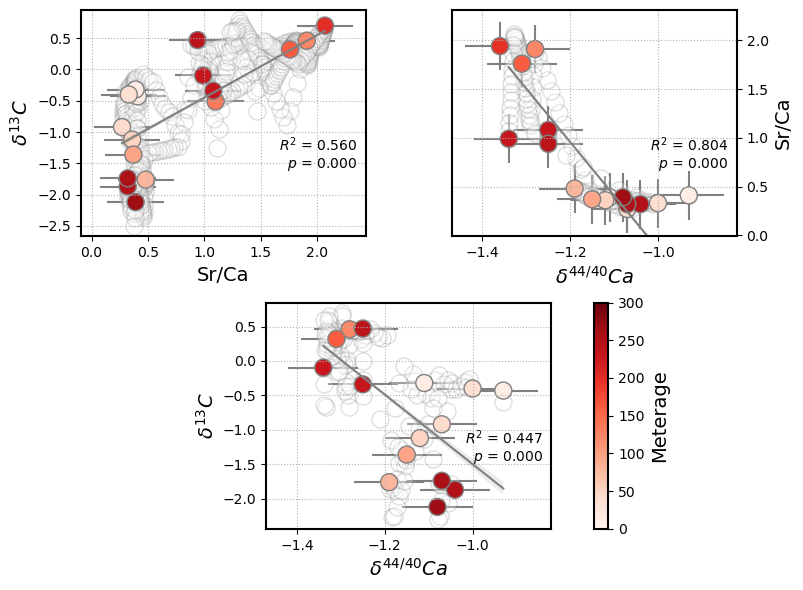

In [6]:
fig, axs = subplots_centered(nrows=2, ncols=2, figsize=(8,6), nfigs=3)

ax = axs[0]
ax1 = axs[1]
ax2 = axs[2]

ax.scatter(df["Sr/Ca"], df["d13C"], c=df["Meterage"], cmap='Reds', 
           vmin=0, vmax=300, ec='gray', s=150)
ax.scatter(SrCa_resampled[::5], d13C_resampled[::5], fc='white', 
           ec='gray', alpha=0.25, s=150, zorder=-1)
ax.errorbar(df["Sr/Ca"], df["d13C"], xerr=0.25, fmt='none', ecolor='gray',
            zorder=-2)




ax1.scatter(df["d44Ca"], df["Sr/Ca"], c=df["Meterage"], cmap='Reds', 
           vmin=0, vmax=300, ec='gray', s=150)
ax1.scatter(d44Ca_resampled[::20], SrCa_resampled[::20], fc='white', 
           ec='gray', alpha=0.25, s=150, zorder=-1)
ax1.errorbar(df["d44Ca"], df["Sr/Ca"], xerr=0.08, yerr=0.25, fmt='none', ecolor='gray',
            zorder=-2)

ax1.tick_params(axis='y', left=False, right=True, labelleft=False,
                labelright=True)
ax1.yaxis.set_label_position('right')
ax1.set_ylim(-0.01, 2.31)


mplot = ax2.scatter(df["d44Ca"], df["d13C"], c=df["Meterage"], cmap='Reds', 
           vmin=0, vmax=300, ec='gray', s=150)
ax2.scatter(d44Ca_resampled[::20], d13C_resampled[::20], fc='white', 
           ec='gray', alpha=0.25, s=150, zorder=-1)
ax2.errorbar(df["d44Ca"], df["d13C"], xerr=0.08, fmt='none', ecolor='gray',
            zorder=-2)

for a in [ax, ax1, ax2]:
    a.grid(linestyle=":")

# Add p and r values
for a, r, p, x, y, cnt in zip([ax, ax1, ax2], Rs,
                   Ps, Xs, Ys, range(len(Xs))):
    a.text(0.97, 0.3, '$R^2$ = {:.3f}\n$p$ = {:.3f}'.format(r**2, p),
           transform=a.transAxes, ha='right')
    sns.regplot(x=x, y=y, ax=a, scatter=False,
                line_kws=dict(color="grey", lw=1.5))

ax.set_xlabel('Sr/Ca', fontsize=14)
ax.set_ylabel('$\delta^{13}C$', fontsize=14)
ax1.set_ylabel('Sr/Ca', fontsize=14)
ax1.set_xlabel('$\delta^{44/40}Ca$', fontsize=14)
ax2.set_xlabel('$\delta^{44/40}Ca$', fontsize=14)
ax2.set_ylabel('$\delta^{13}C$', fontsize=14)


fig.tight_layout()

axins = inset_axes(
    ax2,
    width="5%",  # width: 5% of parent_bbox width
    height="100%",  # height: 50%
    loc="lower left",
    bbox_to_anchor=(1.15, 0., 1, 1),
    bbox_transform=ax2.transAxes,
    borderpad=0,
)

# Add colorbar
cbar = fig.colorbar(mplot, cax=axins)
cbar.ax.set_ylabel('Meterage', fontsize=14)